# Presentación Grupo 6

## Machine Learning

### Autores: Yasser Aoujil, Joaquín Trillo Escribano , Iván José Alba García
<br>
<br>


In [1]:
import matplotlib.pyplot as plt
from pymongo import MongoClient, GEOSPHERE, ASCENDING, DESCENDING
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn import datasets
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_session_mon(db_name):
    """
    :param db_name: Nombre de la base de datos de los incidentes y los distritos
    :return: Objeto de tipo DataBase con una conexión a la base de datos local
    """
    client = MongoClient()
    db = client[db_name]
    return db
sfdb_mon = get_session_mon("san_francisco_incidents")  # Obtenemos una sesión con la bd usando su nombre

In [3]:
# Especificamos los campos que queremos para seleccionar desde MongoDB
target_fields = {
    'Category':1,
    'DayOfWeek':1,
    'PdDistrict':1,
    'Resolution':1
}
# Select lo hacemos usando el primero sort para ordenar según la fecha y luego limitamos sólo a 10000
incidents_ml = sfdb_mon.incidents.find({},target_fields).sort('Date', DESCENDING).limit(100000);
df_ml = pd.DataFrame(list(incidents_ml))
df_ml = df_ml.drop(['_id'], axis=1) # Quitamos el campo _id que siempre viene por defecto
df_ml.__len__() # Vemos el tamaño del df que debe ser 10000

100000

In [4]:
df_ml.head()

,Category,DayOfWeek,PdDistrict,Resolution
0,KIDNAPPING,Saturday,MISSION,"ARREST, BOOKED"
1,SECONDARY CODES,Saturday,MISSION,"ARREST, BOOKED"
2,OTHER OFFENSES,Saturday,MISSION,"ARREST, BOOKED"
3,ASSAULT,Saturday,MISSION,"ARREST, BOOKED"
4,VANDALISM,Saturday,NORTHERN,NONE


## Classification

In [5]:
class_df = df_ml.copy() # Dataframe de clasificación
# Convertimos los demás campos a tipo Categoría de pandas
class_df.PdDistrict = pd.Categorical(class_df.PdDistrict)
class_df.DayOfWeek = pd.Categorical(class_df.DayOfWeek)
class_df.Resolution = pd.Categorical(class_df.Resolution)
# En vez de Strings vamos a guardar los códigos en los valores
class_df['PdDistrict'] = class_df.PdDistrict.cat.codes
class_df['DayOfWeek'] = class_df.DayOfWeek.cat.codes
class_df['Resolution'] = class_df.Resolution.cat.codes
class_df.head()

,Category,DayOfWeek,PdDistrict,Resolution
0,KIDNAPPING,2,3,0
1,SECONDARY CODES,2,3,0
2,OTHER OFFENSES,2,3,0
3,ASSAULT,2,3,0
4,VANDALISM,2,4,8


In [6]:
# Split-out validation dataset
array = class_df.values
X = array[:,1:4]
Y = array[:,0] # El campo categoría es el primero
validation_size = 0.20 # Usamos 20% para la validación y el resto para el entrenamiento
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.376425 (0.006599)
LDA: 0.376650 (0.006621)
KNN: 0.279412 (0.015473)
CART: 0.378100 (0.006092)
NB: 0.072463 (0.003296)


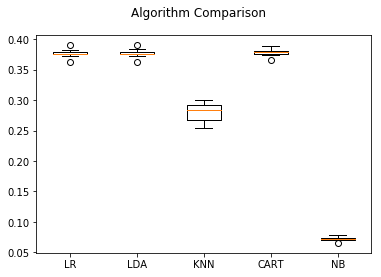

In [7]:
# Comparamos los algoritmos
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [8]:
# Viendo el resultado, el CART ha sido el mejor
CART = DecisionTreeClassifier()
CART.fit(X_train, Y_train)
predictions = CART.predict(X_validation)

print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.3699
[[ 0  0  0 ...  0  0  0]
 [ 0 14  0 ...  0 10  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  1  0 ...  5  0  0]
 [ 0 11  0 ...  0 10  0]
 [ 0  3  0 ...  0  0  0]]
                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00        41
                    ASSAULT       0.16      0.01      0.01      1823
                 BAD CHECKS       0.00      0.00      0.00         2
                    BRIBERY       0.00      0.00      0.00         5
                   BURGLARY       0.20      0.00      0.00       808
         DISORDERLY CONDUCT       0.00      0.00      0.00        44
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00        28
              DRUG/NARCOTIC       0.19      0.10      0.13       421
                DRUNKENNESS       0.00      0.00      0.00        53
               EMBEZZLEMENT       0.00      0.00      0.00        18
                  EXTORTION       0.00      0.00      0.00         6
        

## Clustering

In [9]:
# Dataframe del cluster, copiado del dataframe original, y hay que hacer el mismo tratamiento
# y limpiza que se le ha hecho al de clasificación
df_cluster = df_ml.copy()
df_target = df_ml[['PdDistrict']]
df_cluster = df_cluster.drop(['PdDistrict'], axis=1)
df_cluster.head()

,Category,DayOfWeek,Resolution
0,KIDNAPPING,Saturday,"ARREST, BOOKED"
1,SECONDARY CODES,Saturday,"ARREST, BOOKED"
2,OTHER OFFENSES,Saturday,"ARREST, BOOKED"
3,ASSAULT,Saturday,"ARREST, BOOKED"
4,VANDALISM,Saturday,NONE


In [10]:
# Convertimos a tipo Categorical y luego cambiamos los valores a tipo numérico
df_cluster.Category = pd.Categorical(df_cluster.Category)
df_cluster.DayOfWeek = pd.Categorical(df_cluster.DayOfWeek)
df_cluster.Resolution = pd.Categorical(df_cluster.Resolution)
df_target.PdDistrict = pd.Categorical(df_target.PdDistrict)

df_cluster['Category'] = df_cluster.Category.cat.codes
df_cluster['DayOfWeek'] = df_cluster.DayOfWeek.cat.codes
df_cluster['Resolution'] = df_cluster.Resolution.cat.codes
df_target['PdDistrict'] = df_target.PdDistrict.cat.codes

In [11]:
# Creamos un array de colores, un color por cada distrito
colors = np.array(['red', 'green', 'blue','pink', 'yellow', 'purple', 'black', 'grey', 'brown', 'orange'])

In [12]:
# Pasamos a ajustar un modelo usando Kmeans con un k=10
model = KMeans(n_clusters=10)
model.fit(df_cluster)
model.labels_

array([4, 4, 4, ..., 3, 9, 4], dtype=int32)

Text(0.5,1,"Model's classification")

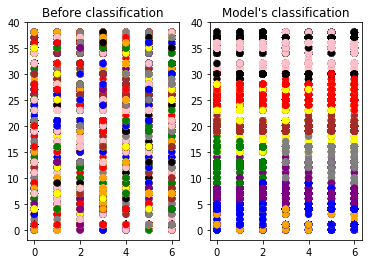

In [13]:
# The fudge to reorder the cluster ids.
predictedY = np.choose(model.labels_, [0,1,2,3,4,5,6,7,8,9]).astype(np.int64)
# Ahora mostramos el resultado después de haber ajustado el modelo a los datos, vamosa  ver cómo quedan
# los datos de categoría con respecto al día de la semana antes y después del ajuste.
plt.subplot(1, 2, 1)
plt.scatter(df_cluster['DayOfWeek'], df_cluster['Category'], c=colors[df_target['PdDistrict']], s=40 )
plt.title('Before classification')
 
# Plot the classifications according to the model
plt.subplot(1, 2, 2)
plt.scatter(df_cluster['DayOfWeek'], df_cluster['Category'], c=colors[predictedY], s=40)
plt.title("Model's classification")